In [8]:
import os
import yaml
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing import List, TypedDict, Annotated
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
"""
from langchain.vectorstores import FAISS
from langchain_core.graph import Graph, Node, StartNode, StopNode
from langchain.docstore.document import Document
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
"""

# Load environment variables
load_dotenv()
api_key = os.environ["groq"]

# Initialize LLM
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=api_key
)
llm_ds= ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    api_key=api_key
    # other params...
)

In [10]:
llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [11]:
llm.invoke("where is taj mahal?").content

'The Taj Mahal is located in Agra, a city in the Indian state of Uttar Pradesh. It is situated on the southern bank of the Yamuna River, approximately 230 kilometers (143 miles) south of New Delhi, the capital city of India.\n\nThe exact address of the Taj Mahal is:\n\nTaj Mahal, Dharmapuri, Forest Colony, Tajganj, Agra, Uttar Pradesh 282001, India\n\nIt is one of the most famous and iconic landmarks in India, and a popular tourist destination, attracting millions of visitors each year.'

In [10]:
resume,personal_info="","""As a HR Analyst and a Talent Acquisition Specialist at Deloitte, I apply my skills to support the organization's human capital strategy and goals. 

I also leverage my recruiting experience from my previous roles at Accenture and PwC India to source, screen, and hire qualified candidates for various positions at Deloitte, ensuring a smooth and positive candidate experience. I am passionate about finding and attracting talent that matches the organization's culture and values, and that can contribute to its growth and success. I am always eager to learn new things and explore new opportunities in the HR and data science fields."""
with open('/workspaces/github_analysis/data/job_description.txt', 'r') as file:
    job_description=file.read()
loader = PyPDFLoader("/workspaces/github_analysis/data/resume_with_capg.pdf")
documents = loader.load()
for i in documents:
    resume+=(i.page_content.strip())
    
with open('/workspaces/github_analysis/src/prompts.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
def intro():

    print("*"*100)
    for i,j in enumerate(data.keys()):
        print(f"{i+1}. {j}")
def inputs():
    i=input("Enter the number corresponding to the key you want to use: ")
    print("selected number is ",int(i))
    key=list(data.keys())[int(i)-1]
    return key

def func(key):
    input_variables=list(data[key]["inputs"].keys())
    template=data[key]["prompt"].format(resume=resume, job_description=job_description,personal_info=personal_info)
    prompt_template = PromptTemplate(
        input_variables=input_variables,
        template=template
    )
    print(prompt_template,input_variables)
    chain=prompt_template | llm
    response=chain.invoke(data[key]["inputs"]).content
    return response

In [23]:
intro()


****************************************************************************************************
1. resume_and_job_decription_rewrite
2. cold_mail_and_person_info
3. cold_mail_no_personal_info


In [28]:
x=inputs()

selected number is  2


In [29]:
print(func(x))

input_variables=[] input_types={} partial_variables={} template='"""\nUsing the following resume, write a professional and inquisitive cold mail tailored to the provided person\'s information, seeking job opportunities:\n\nResume: Dinesh\tSagar\n+91-8121909150\n\t\nMail\n\t\nGitHub\n\t\nLinkedIn\tProfile\nPassionate\tData\tScientist\twith\ta\tdrive\tto\ttackle\treal-world\tchallenges\tthrough\tdata\tanalysis\tand\tmachine\tlearning.\nCommitted\tto\textracting\tvalue\tfrom\tcomplex\tdata\tand\tdelivering\tactionable\tinsights\tto\tinform\tbusiness\tdecisions\t\nand\ndrive\tgrowth.\tEager\tto\tcontinuously\tlearn\tand\timprove\tto\tdeliver\timpactful\tsolutions.\nExperience\nCapgemini\nConsultant\nFEB\t2025-\tPRESENT\nAmazon\tDevelopment\tCentre\tIndia\nQuality\tSpecialist\nJAN\t2020\t-\tDEC\t2024\nImplemented\tan\toutlier\tdetection\tprogram\tto\nenhance\taddress\tdata\tquality,\timproving\tlogistics\nperformance\tfor\tAmazon\tLogistics.\nAnalyzed\tlarge-scale\tdatasets\tusing\tstatisti

In [16]:
import os
os.getcwd()
os.chdir("/workspaces/github_analysis/")


In [8]:
os.getcwd()

'/workspaces/github_analysis/research'

In [19]:
os.chdir("/workspaces/github_analysis/")
from src.helpers import *

In [17]:
data

{'resume_and_job_decription_rewrite': {'tool_use_case': 'use this tool to rewrite a resume based on a job description provided.',
  'prompt': '"""\nRewrite the following resume to match the job description provided:\n\nResume: {resume}\n\nJob Description: {job_description}\n\nInstructions:\n1) Use the available experience, projects, and skills to rewrite the resume.\n2) Don\'t Halucinate.\n3) Don\'t use any external data but only the resume and job description.\n4) Don\'t mention any comments and preamble in the response.\n"""\n',
  'inputs': {'resume': 'resume', 'job_description': 'job_description'}},
 'cold_mail_and_person_info': {'tool_use_case': "use this tool to write a professional and inquisitive cold mail tailored to a person's information, seeking job opportunities.",
  'prompt': '"""\nUsing the following resume, write a professional and inquisitive cold mail tailored to the provided person\'s information, seeking job opportunities:\n\nResume: {resume}\n\nPerson Information: {

In [21]:
data.keys()

dict_keys(['resume_and_job_decription_rewrite', 'cold_mail_and_person_info', 'cold_mail_no_personal_info'])

In [6]:
from langchain_core.tools import tool

def make_tool_func(key):
    code = f'''
@tool
def {key}():
    """
    Description
    {data[key]["tool_use_case"]}
    """
    input_variables = list(data[key]["inputs"].keys())
    template = data[key]["prompt"].format(
        resume=resume, job_description=job_description, personal_info=personal_info
    )
    prompt_template = PromptTemplate(
        input_variables=input_variables,
        template=template
    )
    chain = prompt_template | llm
    response = chain.invoke(data[key]["inputs"]).content
    return response
'''
    local_vars = {}
    exec(code, globals(), local_vars)
    return local_vars[key]

for key in data.keys():
    globals()[key] = make_tool_func(key)

In [23]:
llm1=llm_ds.bind_tools(tools=[globals()[key] for key in data.keys()])

In [24]:
llm1.invoke(f"""write a cold mail when resume {resume} and personal _info {personal_info} is given""")

AIMessage(content='', additional_kwargs={'reasoning_content': "Alright, let me try to figure out how to approach this user's query. They've provided a resume for Dinesh Sagar and a personal info section for someone in talent acquisition. They want to write a cold mail, so I need to determine which tool to use.\n\nLooking at the tools available, there's one for when personal info is available and another for when it's not. Since the user provided personal info about the recipient, I should use the cold_mail_and_person_info tool.\n\nNow, I need to structure the arguments correctly. The resume and personal info should be passed as separate strings. I'll make sure to format them properly in JSON, escaping any special characters if necessary.\n\nI should also ensure that the function call is correctly wrapped in the tool_call XML tags as specified. Double-checking the function name and the structure of the arguments is crucial to avoid any errors.\n\nFinally, I'll present the tool_call with

In [37]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    option:str


graph = StateGraph(State)

In [7]:
import os
import yaml
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing import List, TypedDict, Annotated
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
"""
from langchain.vectorstores import FAISS
from langchain_core.graph import Graph, Node, StartNode, StopNode
from langchain.docstore.document import Document
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
"""

# Load environment variables
load_dotenv()
api_key = os.environ["groq"]

# Initialize LLM
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=api_key
)
def intro1(state: State) -> State:
    """
    This is the first node in the graph. It initializes the messages state.
    """
    print("*"*100)
    for i,j in enumerate(data.keys()):
        print(f"{i+1}. {j}")

    i=input("Enter the number corresponding to the key you want to use: ")
    print("selected number is ",int(i))
    key=list(data.keys())[int(i)-1]
    state["option"] = key
    state["messages"] = [AIMessage(content=f"Selected option is {key}.")]
    return state

NameError: name 'State' is not defined

In [58]:
"""defining llm to assess the input from the introl and selectin the appropriate tool to use  """
def llm_fx(state: State) -> State:
    """
    This node uses the selected option to invoke the corresponding tool.
    """
    key = state["option"]
    input_variables = list(data[key]["inputs"].keys())
    template = data[key]["prompt"].format(
        resume=resume, job_description=job_description, personal_info=personal_info
    )
    prompt_template = PromptTemplate(
        input_variables=input_variables,
        template=template
    )
    chain = prompt_template | llm
    response = chain.invoke(data[key]["inputs"]).content
    state["messages"].append(AIMessage(content=response))
    return state

In [59]:
""" Adding edges and nodes to the graph """
tools = [globals()[key] for key in data.keys()]
tool_node = ToolNode(tools=tools)

graph.add_node("input", intro1)
graph.add_node("llm", llm_fx)
graph.add_node("tools", tool_node)
graph.add_edge(START, "input")


graph.add_edge("input", "llm")
graph.add_edge("llm","tools")
graph.add_edge("tools",END)  # Add a single node with all tools


Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `input` already present.

In [60]:
graph1 = graph.compile()

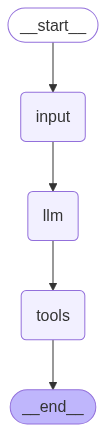

In [61]:
from IPython.display import Image, display

try:
    display(Image(graph1.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [62]:
graph1.invoke({"messages":["hi please write a cold mail using the resume and personal info"]})

****************************************************************************************************
1. resume_and_job_decription_rewrite
2. cold_mail_and_person_info
3. cold_mail_no_personal_info
selected number is  2


{'messages': [HumanMessage(content='hi please write a cold mail using the resume and personal info', additional_kwargs={}, response_metadata={}, id='1722847f-22ab-4936-9881-18efba3c9f6c'),
  AIMessage(content='Selected option is cold_mail_and_person_info.', additional_kwargs={}, response_metadata={}, id='e3d4d067-e798-4ae2-bf67-3732615323e5'),
  AIMessage(content="Hi, I came across your profile and was impressed with your experience in data science and machine learning, particularly your projects on Generative AI and Computer Vision. I'd love to explore potential opportunities at Deloitte that align with your skills. Can we discuss further? Regards, Dinesh Sagar", additional_kwargs={}, response_metadata={}, id='b024dbe0-f209-41d0-8d15-6dbba70887c8')],
 'option': 'cold_mail_and_person_info'}

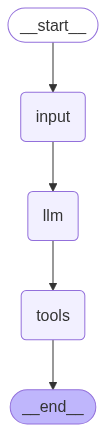

****************************************************************************************************
1. resume_and_job_decription_rewrite
2. cold_mail_and_person_info
3. cold_mail_no_personal_info


In [ ]:
import os
import yaml
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

#from langchain_core.tools import ToolNode
from langchain_core.messages import AIMessage

def run_graph(data: dict, resume: str, job_description: str, personal_info: str,message:str) -> None:
    """
    This function initializes the environment, sets up the LLM, and runs the graph based on user input.

    Args:
        data (dict): A dictionary containing the options and prompts.
        resume (str): The user's resume.
        job_description (str): The job description.
        personal_info (str): The user's personal information.
    """
    # Load environment variables
    load_dotenv()
    api_key = os.environ["groq"]

    # Initialize LLM
    llm = ChatGroq(
        model="llama-3.3-70b-versatile",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key=api_key
    )

    # Initialize the graph
    class State(TypedDict):
        # Messages have the type "list". The `add_messages` function
        # in the annotation defines how this state key should be updated
        # (in this case, it appends messages to the list, rather than overwriting them)
        messages: Annotated[list, add_messages]
        option:str


    graph = StateGraph(State)

    def intro1(state: dict) -> dict:
        """
        This is the first node in the graph. It initializes the messages state.
        """
        print("*" * 100)
        for i, j in enumerate(data.keys()):
            print(f"{i + 1}. {j}")

        i = input("Enter the number corresponding to the key you want to use: ")
        key = list(data.keys())[int(i) - 1]
        state["option"] = key
        state["messages"] = [AIMessage(content=f"Selected option is {key}.")]
        return state

    def llm_fx(state: dict) -> dict:
        """
        This node uses the selected option to invoke the corresponding tool.
        """
        key = state["option"]
        input_variables = list(data[key]["inputs"].keys())
        template = data[key]["prompt"].format(
            resume=resume, job_description=job_description, personal_info=personal_info
        )
        prompt_template = PromptTemplate(
            input_variables=input_variables,
            template=template
        )
        chain = prompt_template | llm
        response = chain.invoke(data[key]["inputs"]).content
        state["messages"].append(AIMessage(content=response))
        return state

    # Adding edges and nodes to the graph
    tools = [globals()[key] for key in data.keys()]
    tool_node = ToolNode(tools=tools)

    graph.add_node("input", intro1)
    graph.add_node("llm", llm_fx)
    graph.add_node("tools", tool_node)
    graph.add_edge(START, "input")
    graph.add_edge("input", "llm")
    graph.add_edge("llm", "tools")
    graph.add_edge("tools", END)

    graph1 = graph.compile()

    # Display the graph (optional)
    from IPython.display import Image, display
    try:
        display(Image(graph1.get_graph().draw_mermaid_png()))
    except Exception:
        pass

    # Invoke the graph with a sample message
    graph1.invoke({"messages": [message]})

# Example usage
run_graph(data, resume, job_description, personal_info,message=f"{state["option"]}")


In [30]:
resume,personal_info="","""As a HR Analyst and a Talent Acquisition Specialist at Deloitte, I apply my skills to support the organization's human capital strategy and goals. 

I also leverage my recruiting experience from my previous roles at Accenture and PwC India to source, screen, and hire qualified candidates for various positions at Deloitte, ensuring a smooth and positive candidate experience. I am passionate about finding and attracting talent that matches the organization's culture and values, and that can contribute to its growth and success. I am always eager to learn new things and explore new opportunities in the HR and data science fields."""
with open('/workspaces/github_analysis/data/job_description.txt', 'r') as file:
    job_description=file.read()
loader = PyPDFLoader("/workspaces/github_analysis/data/resume_with_capg.pdf")
documents = loader.load()
for i in documents:
    resume+=(i.page_content.strip())
    
with open('/workspaces/github_analysis/src/prompts.yaml', 'r') as file:
    data = yaml.safe_load(file)
    

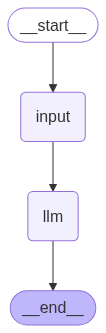

****************************************************************************************************
1. resume_and_job_decription_rewrite
2. cold_mail_and_person_info
3. cold_mail_no_personal_info
Final Result: Dinesh Sagar
+91-8121909150

Mail
GitHub
LinkedIn Profile
Passionate Data Scientist with a drive to tackle real-world challenges through data analysis and machine learning, committed to extracting value from complex data and delivering actionable insights to inform business decisions and drive growth.

Experience
Capgemini
Consultant
FEB 2025- PRESENT
Amazon Development Centre India
Quality Specialist
JAN 2020 - DEC 2024
Implemented an outlier detection program to enhance address data quality, improving logistics performance for Amazon Logistics using statistical methods and machine learning models.
Analyzed large-scale datasets to optimize delivery operations and resource planning, and built time series models to forecast peak order volumes, enabling proactive logistics managem

In [31]:
import os
import yaml
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage

def run_graph(data: dict, resume: str, job_description: str, personal_info: str) -> None:
    """
    This function initializes the environment, sets up the LLM, and runs the graph based on user input.

    Args:
        data (dict): A dictionary containing the options and prompts.
        resume (str): The user's resume.
        job_description (str): The job description.
        personal_info (str): The recruiter's personal information.
    """
    # Load environment variables
    load_dotenv()
    api_key = os.environ["groq"]

    # Initialize LLM
    llm = ChatGroq(
        model="llama-3.3-70b-versatile",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key=api_key
    )

    # Initialize the graph
    class State(TypedDict):
        messages: Annotated[list, add_messages]
        option: str

    graph = StateGraph(State)

    def intro1(state: State) -> dict:
        """
        This is the first node in the graph. It initializes the messages state.
        """
        print("*" * 100)
        for i, j in enumerate(data.keys()):
            print(f"{i + 1}. {j}")

        i = input("Enter the number corresponding to the key you want to use: ")
        key = list(data.keys())[int(i) - 1]
        state["option"] = key
        state["messages"] = [AIMessage(content=f"Selected option is {key}.")]
        return state

    def llm_fx(state: State) -> dict:
        """
        This node uses the selected option to invoke the corresponding tool.
        """
        key = state["option"]
        input_variables = list(data[key]["inputs"].keys())
        template = data[key]["prompt"].format(
            resume=resume, job_description=job_description, personal_info=personal_info
        )
        prompt_template = PromptTemplate(
            input_variables=input_variables,
            template=template
        )
        chain = prompt_template | llm
        response = chain.invoke(data[key]["inputs"]).content
        state["messages"].append(AIMessage(content=response))
        return state

    # Adding nodes and edges to the graph without tools
    graph.add_node("input", intro1)
    graph.add_node("llm", llm_fx)
    graph.add_edge(START, "input")
    graph.add_edge("input", "llm")
    graph.add_edge("llm", END)  # Directly connect llm to END

    graph1 = graph.compile()

    # Display the graph (optional)
    from IPython.display import Image, display
    try:
        display(Image(graph1.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Error displaying graph: {e}")

    # Invoke the graph with a sample message
    # Display the final result to the user
    final_state = graph1.invoke({"messages": ["Welcome to the graph!"]})
    final_response = final_state["messages"][-1].content  # Get the last message from the state
    print("Final Result:", final_response)

# Example usage
# Define your data, resume, job description, and personal info before calling the function
# data = {...}
# resume = "..."
# job_description = "..."
# personal_info = "..."
response=run_graph(data, resume, job_description, personal_info)


In [32]:
import streamlit as st

In [33]:
import streamlit as st
import os
import yaml
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage

# Load environment variables
load_dotenv()
api_key = os.environ["groq"]

# Initialize LLM
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=api_key
)

def run_graph(data: dict, resume: str, job_description: str, personal_info: str) -> None:
    class State(TypedDict):
        messages: Annotated[list, add_messages]
        option: str

    graph = StateGraph(State)

    def intro1(state: State) -> dict:
        state["option"] = st.session_state["option"]
        state["messages"] = [AIMessage(content=f"Selected option is {state['option']}.")]
        return state

    def llm_fx(state: State) -> dict:
        key = state["option"]
        input_variables = list(data[key]["inputs"].keys())
        template = data[key]["prompt"].format(
            resume=resume, job_description=job_description, personal_info=personal_info
        )
        prompt_template = PromptTemplate(
            input_variables=input_variables,
            template=template
        )
        chain = prompt_template | llm
        response = chain.invoke(data[key]["inputs"]).content
        state["messages"].append(AIMessage(content=response))
        return state

    graph.add_node("input", intro1)
    graph.add_node("llm", llm_fx)
    graph.add_edge(START, "input")
    graph.add_edge("input", "llm")
    graph.add_edge("llm", END)

    graph1 = graph.compile()

    final_state = graph1.invoke({"messages": ["Welcome to the graph!"]})
    final_response = final_state["messages"][-1].content  
    return final_response

def main():
    st.title("Graph App")

    with open('/workspaces/github_analysis/src/prompts.yaml', 'r') as file:
        data = yaml.safe_load(file)

    options = list(data.keys())
    st.selectbox("Select an option", options, key="option")

    uploaded_resume = st.file_uploader("Upload your resume", type=["pdf", "docx", "txt"])

    if uploaded_resume is not None:
        resume = uploaded_resume.read().decode("utf-8")
        st.write("Resume uploaded successfully!")

    job_description = st.text_area("Enter the job description")
    personal_info = st.text_area("Enter your personal info")

    if st.button("Run") and uploaded_resume is not None:
        response = run_graph(data, resume, job_description, personal_info)
        st.write("Final Result:", response)

if __name__ == "__main__":
    main()


2025-07-23 07:09:56.534 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 07:09:56.642 
  command:

    streamlit run /workspaces/github_analysis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-07-23 07:09:56.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 07:09:56.644 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 07:09:56.649 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 07:09:56.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 07:09:56.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-23 07:09:56.653 Thr

In [13]:
from helpers_final import *

In [6]:
llm=LLM().llm

In [7]:
llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [14]:
fx=functions()

NameError: name 'functions' is not defined